In [9]:
import numpy as np
import pickle
np.random.seed(0)

In [10]:
with open("test.pickle", "rb") as f:
    test = pickle.load(f)

In [11]:
with open("train.pickle", "rb") as f:
    train = pickle.load(f)

In [13]:
with open("ratings.pickle", "rb") as f:
    ratings = pickle.load(f)

In [14]:
temp = test

test = train

train = temp

In [15]:
from sklearn.metrics import mean_squared_error
def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [16]:
np.mean(test[np.where(test != 0)])

3.484741399995637

In [17]:
def predict(global_bias, item_bias, user_bias, user_vectors, item_vectors, i, u):
    prediction = global_bias + item_bias[i] + user_bias[u]
    prediction += user_vectors[u,:].dot(item_vectors[i,:].T)
    return prediction

def predictAll(global_bias, item_bias, user_bias, user_vectors, item_vectors):
    predictions = np.zeros((user_vectors.shape[0], item_vectors.shape[0]))
    for u in range(user_vectors.shape[0]):
        for i in range(item_vectors.shape[0]):
            predictions[u, i] = predict(global_bias, item_bias, user_bias, user_vectors, item_vectors, i, u)
                
    return predictions

def scd(ratings, learning_rate, item_bias_reg, user_bias_reg, item_fact_reg, user_fact_reg, iter_no,  n_factors = 40):
    number_users, number_items = ratings.shape
    user_vectors = np.random.normal(scale = 1./n_factors, size=(number_users, n_factors))
    item_vectors = np.random.normal(scale = 1./n_factors, size=(number_items, n_factors))
    row, column = np.nonzero(ratings)
    numberOfItems = len(row)
    indexes = np.arange(numberOfItems)
    np.random.shuffle(indexes)
    user_bias = np.zeros(number_users)
    item_bias = np.zeros(number_items)
    global_bias = np.mean(ratings[np.where(ratings != 0)])
    for i in range(iter_no):
        for idx in indexes:
            u = row[idx]
            i = column[idx]
            prediction = predict(global_bias, item_bias, user_bias, user_vectors, item_vectors, i, u)
            
            e = ratings[u,i] - prediction
            user_bias[u] += learning_rate*(e-user_bias_reg*user_bias[u])
            item_bias[i] += learning_rate*(e-item_bias_reg*item_bias[i])
            
            user_vectors[u,:] += learning_rate*(e*item_vectors[i,:] - user_fact_reg*user_vectors[u,:])
            item_vectors[i,:] += learning_rate*(e*user_vectors[u,:] - item_fact_reg*item_vectors[i,:])

    return global_bias, item_bias, user_bias, user_vectors, item_vectors    

In [8]:
train.shape

(610, 9742)

In [18]:
global_bias, item_bias, user_bias, user_vectors, item_vectors = scd(ratings, 0.0001, 1.0, 0.0, 1.0, 0.0, 1)

In [19]:
item_bias

array([ 8.83994130e-03, -7.13455030e-04, -1.22542251e-03, ...,
       -1.63545767e-08, -4.80705971e-07,  4.92384324e-05])

In [20]:
prediction = predictAll(global_bias, item_bias, user_bias, user_vectors, item_vectors)

In [21]:
prediction = np.where(np.isnan(prediction), 0, prediction)

prediction = np.where(np.isinf(prediction), 0, prediction)

In [22]:
get_mse(prediction, test)

1.0520325492341702

In [156]:
%%time
counter = 0
iterations = [1,2,5,10,50,100]
training = []
testing = []
for iter_no in iterations:
    global_bias, item_bias, user_bias, user_vectors, item_vectors = scd(train, 0.0001, 0.0, 0.0, 0.0, 0.0, iter_no)
    prediction = predictAll(global_bias, item_bias, user_bias, user_vectors, item_vectors)
    training.append(get_mse(prediction, train))
    testing.append(get_mse(prediction, test))
    counter += 1
    print(f'counter no {counter} got done')

counter no 1 got done
counter no 2 got done
counter no 3 got done
counter no 4 got done
counter no 5 got done
counter no 6 got done
CPU times: user 4min 43s, sys: 2.46 s, total: 4min 46s
Wall time: 4min 44s


In [157]:
training

[1.0535658994967643,
 1.0347872387231412,
 1.002775193612296,
 1.0047617354079206,
 2.206389741423562,
 21.520729082492487]

Text(0, 0.5, 'MSE')

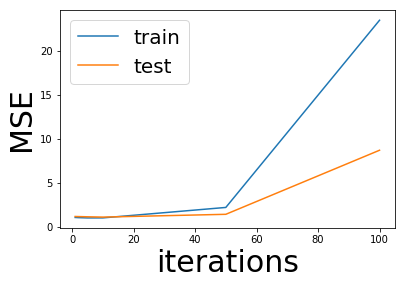

In [149]:
import matplotlib.pyplot as plt
plt.plot(iterations, training, label='train')
plt.plot(iterations, testing, label='test')
plt.legend(loc = 'best', fontsize=20)
plt.xlabel('iterations', fontsize=30)
plt.ylabel('MSE', fontsize=30)

In [162]:
%%time
counter = 0
k = [5,10,20,40,80]
training_k = []
testing_k = []
for iter_no in k:
    global_bias, item_bias, user_bias, user_vectors, item_vectors = scd(train, 0.0001, 0.0, 0.0, 0.0, 0.0, 10, iter_no)
    prediction = predictAll(global_bias, item_bias, user_bias, user_vectors, item_vectors)
    training_k.append(get_mse(prediction, train))
    testing_k.append(get_mse(prediction, test))
    counter += 1
    print(f'counter no {counter} got done')

counter no 1 got done
counter no 2 got done
counter no 3 got done
counter no 4 got done
counter no 5 got done
CPU times: user 1min 59s, sys: 1.16 s, total: 2min
Wall time: 1min 59s


Text(0, 0.5, 'MSE')

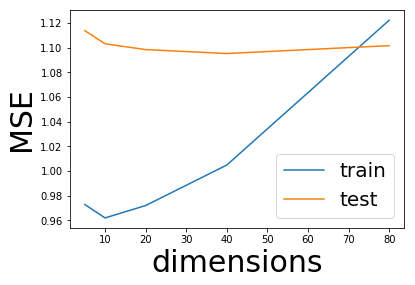

In [163]:
import matplotlib.pyplot as plt
plt.plot(k, training_k, label='train')
plt.plot(k, testing_k, label='test')
plt.legend(loc = 'best', fontsize=20)
plt.xlabel('dimensions', fontsize=30)
plt.ylabel('MSE', fontsize=30)

In [164]:
testing_k

[1.1137717660571893,
 1.1030952756719024,
 1.0983904494837953,
 1.0952019732534477,
 1.101596906205597]

## we need 40 value of k
## the iterations should be 10
## the value of learning rate is 0.0001